# textING (Inductive Text Classification via Graph Neural Networks)  

-- Paper : https://arxiv.org/pdf/2004.13826v2.pdf 

- -------------------------------





In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%cd /Users/justdoit/Desktop/Code/2022/

/Users/justdoit/Desktop/Code/2022


In [3]:
# get data (Naver sentiment movie corpus v1.0)
!git clone https://github.com/e9t/nsmc.git

fatal: destination path 'nsmc' already exists and is not an empty directory.


Each file is consisted of three columns: 
<b>id</b>, <b>document</b>, <b>label</b>

<b>id</b>,: The review id, provieded by Naver\
<b>document</b>,: The actual review\
 <b>label</b>: The sentiment class of the review. (0: negative, 1: positive)\
Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)

-- 200K reviews in total
- ratings.txt: All 200K reviews
- ratings_test.txt: 50K reviews held out for testing
- ratings_train.txt: 150K reviews for training

## Get and Prepare Data

In [4]:
data_dir = '/content/drive/MyDrive/2022/nsmc'


train_data = os.path.join(data_dir, 'ratings_train.txt')
test_data = os.path.join(data_dir, 'ratings_test.txt')

In [5]:
trains = pd.read_csv('/Users/justdoit/Desktop/Code/2022/ratings_train.txt', delimiter='\t')
test = pd.read_csv('/Users/justdoit/Desktop/Code/2022/ratings_test.txt', delimiter='\t')

In [6]:
print(len(trains))
print(len(test))

150000
50000


0    75173
1    74827
Name: label, dtype: int64


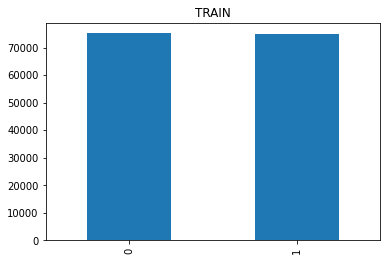

In [ ]:
#check distribution of label [ train ]

trains['label'].value_counts().plot(kind='bar')
plt.title('TRAIN')
print(trains['label'].value_counts())

1    25173
0    24827
Name: label, dtype: int64


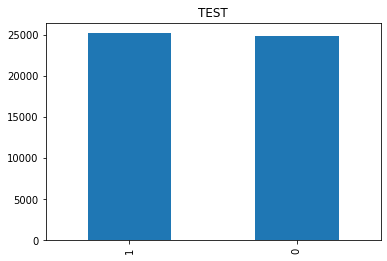

In [ ]:
#check distribution of label [ test ]

test['label'].value_counts().plot(kind='bar')
plt.title('TEST')
print(test['label'].value_counts())

## Preprocessing

### 중복값 및 결측치 제거

In [ ]:
# check unique data size

print(trains['document'].nunique())
print(trains['label'].nunique())
print(test['document'].nunique())
print(test['label'].nunique())

146182
2
49157
2


In [ ]:
# check duplicates

print(trains['document'].duplicated().sum())
print(test['document'].duplicated().sum())

3817
842


In [7]:
# Drop duplicates

trains.drop_duplicates(subset=['document'], inplace=True)
test.drop_duplicates(subset=['document'], inplace=True)

In [ ]:
# check for NAN

print(trains.isnull().sum())
print(test.isnull().sum())

id          0
document    1
label       0
dtype: int64
id          0
document    1
label       0
dtype: int64


In [8]:
trains = trains.dropna(how='any')
test = test.dropna(how='any')

print(trains['document'].nunique())
print(test['document'].nunique())

146182
49157


### 자연어 전처리

### Mecab 다운로드

In [9]:
ls

README.md
Standalone-DeepLearning/
plotly/
ratings_test.txt
ratings_train.txt
sql_python/
vscode_practice/
원티드랩_머신러닝_리서치_인턴_이승재_textING.ipynb


In [10]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+zsh:1> pip install konlpy
     |████████████████████████████████| 19.4 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 381 kB 41.3 MB/s eta 0:00:01
+zsh:1> curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+zsh:1> bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Darwin
+ [[ ! Darwin == \L\i\n\u\x ]]
+ [[ ! Darwin == \D\a\r\w\i\n ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Darwin == Linux ']'
+ '[' Darwin == Darwin ']'
++ command -v brew
+ [[ /opt/homebrew/bin/brew == '' ]]
+ brew install automake
Running `brew update --preinstall`...
==> Auto-updated Homebrew!
Updated 1 tap (homebrew/core).
==> New Formulae
pinot
==> Updated Formulae
Updated 155 formulae.

Error: 

In [11]:
from konlpy.tag import Mecab

### 한글 외 제거

In [10]:
# remove documents that are not Korean.

#trains
trains['document'] = trains['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
trains['document'].replace('',np.nan,inplace=True)
trains = trains.dropna(how='any')
#test
test['document'] = test['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
test['document'].replace('',np.nan,inplace=True)
test = test.dropna(how='any')

print(len(trains))
print(len(test))

145393
48852


0    73043
1    72350
Name: label, dtype: int64


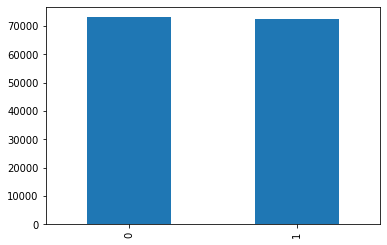

In [ ]:
#check change of distribution of label [ train ]

trains['label'].value_counts().plot(kind='bar')
print(trains['label'].value_counts())

1    24520
0    24332
Name: label, dtype: int64


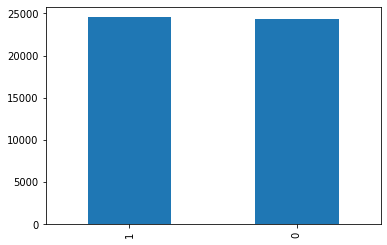

In [ ]:
#check change of distribution of label [ test ]

test['label'].value_counts().plot(kind='bar')
print(test['label'].value_counts())

### 토큰화 및 불용어 제거

In [11]:
stopwords = ['의','가','이','은','을','가','들','는','좀','잘','강','과','도','를','으로','자','에','와','한','하다']

In [12]:
mecab = Mecab()

In [13]:
# function for removing stopwords

def rm_stopwords(x, y):
  for doc in x['document']:
    y.append([word for word in mecab.morphs(doc) if not word in stopwords])

In [14]:
#Change name of variable : trains['document'] -> train_x | test['document'] -> test_x
train_x = []
test_x = []

rm_stopwords(trains,train_x)
rm_stopwords(test, test_x)

In [ ]:
print('removed train stopwords')
print(trains['document'][0])
print(train_x[0],'\n')
print('removed test stopwords')
print(test['document'][0])
print(test_x[0])

removed train stopwords
아더빙진짜짜증나네요목소리
['아', '더', '빙', '진짜', '짜증', '나', '네', '요목', '소리'] 

removed test stopwords
굳ㅋ
['굳', 'ㅋ']


### 단어 길이 확인

In [ ]:
print('TRAIN')
print('min train_document length:' , min(len(doc) for doc in train_x))
print('max train_document length:', max(len(doc) for doc in train_x))
print('average train_document length:', sum(map(len, train_x))/len(train_x),'\n')
print('TEST')
print('min test_document length:' , min(len(doc) for doc in test_x))
print('max test_document length:', max(len(doc) for doc in test_x))
print('average test_document length:', sum(map(len, test_x))/len(test_x))

TRAIN
min train_document length: 0
max train_document length: 82
average train_document length: 13.22637265893131 

TEST
min test_document length: 0
max test_document length: 73
average test_document length: 13.205805289445673


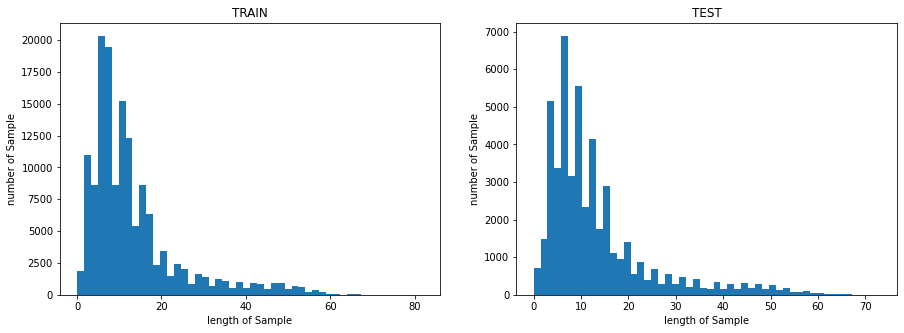

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist([len(doc) for doc in train_x],bins=50)
plt.xlabel('length of Sample')
plt.ylabel('number of Sample')
plt.title('TRAIN')

plt.subplot(1,2,2)
plt.hist([len(doc) for doc in test_x],bins=50)
plt.xlabel('length of Sample')
plt.ylabel('number of Sample')
plt.title('TEST')

plt.show()



- 단어 길이가 1보다 작은 document 삭제

In [15]:
train_y = np.array(trains['label'])
test_y = np.array(test['label'])

- 문장 내에 단어 분포를 확인해보니 1이하와 60이상 단어를 가진 document는 제거합니다.

In [16]:
#Drop document size less or equal to 1 & over 60
train_drop = [idx for idx, doc in enumerate(train_x) if (len(doc)<=1) or (len(doc)>60)]
test_drop = [idx for idx, doc in enumerate(test_x) if (len(doc)<=1) or (len(doc)>60)]

train_x = np.delete(train_x, train_drop,axis=0)
train_y = np.delete(train_y, train_drop,axis=0)

#delete the same document label for label data
test_x = np.delete(test_x, test_drop,axis=0)
test_y = np.delete(test_y, test_drop,axis=0)

print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_y))

143288
143288
48068
48068


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
print('TRAIN')
print('min train_document length:' , min(len(doc) for doc in train_x))
print('max train_document length:', max(len(doc) for doc in train_x))
print('average train_document length:', sum(map(len, train_x))/len(train_x),'\n')
print('TEST')
print('min test_document length:' , min(len(doc) for doc in test_x))
print('max test_document length:', max(len(doc) for doc in test_x))
print('average test_document length:', sum(map(len, test_x))/len(test_x))

TRAIN
min train_document length: 2
max train_document length: 60
average train_document length: 13.307290212718442 

TEST
min test_document length: 2
max test_document length: 60
average test_document length: 13.30055338270783


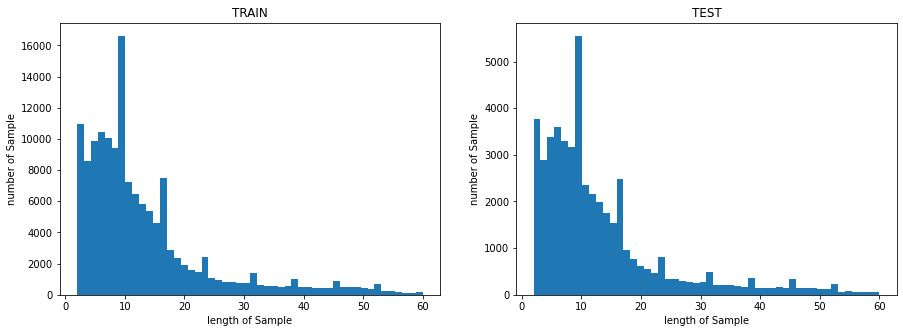

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist([len(doc) for doc in train_x],bins=50)
plt.xlabel('length of Sample')
plt.ylabel('number of Sample')
plt.title('TRAIN')

plt.subplot(1,2,2)
plt.hist([len(doc) for doc in test_x],bins=50)
plt.xlabel('length of Sample')
plt.ylabel('number of Sample')
plt.title('TEST')

plt.show()



### 인접행렬 생성 (window size = 3 )

In [18]:
class adjacency_matrix:

  def __init__(self, document):
    self.document = document
  
  def create_corpus(self):
    words = self.document
    word_to_id = {}
    id_to_word = {}
    for word in words:
      if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])

    return corpus

  def create_adjacency_matrix(self):
    self.window_size = 2
    corpus = self.create_corpus()
    vocab_size = 60 #to create fixed adjacency matrix per document 
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size,vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
      for i in range(1, self.window_size + 1):
        left_idx = idx - i
        right_idx = idx + i

        if left_idx == idx -1:
          left_word_id = corpus[left_idx]
          co_matrix[word_id, left_word_id] += 1
       
        if right_idx < corpus_size:
          right_word_id = corpus[right_idx]
          co_matrix[word_id, right_word_id] += 1
    co_matrix = co_matrix + np.identity(60) #-> 60x60 matrix with identity matrix added
    return co_matrix


    # From https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

In [19]:
Adj = []
for document in train_x:
  adj = adjacency_matrix(document)
  Adj.append(adj.create_adjacency_matrix())

### Node Feature Matrix 생성

In [17]:
!pip install gensim==3.8.3


In [18]:
from gensim.models.word2vec import Word2Vec

In [19]:
%cd ko

/content/drive/My Drive/2022/ko


In [20]:
ko_model = Word2Vec.load('ko.bin')

In [29]:
ko_model.wv.vectors.shape

(30185, 200)

In [38]:
ko_model.wv[train_x[0]].shape

TypeError: ignored

In [ ]:
train_NF = []

for doc in train_x:
  tmp = []
  for words in doc:
    try:
      tmp.append(ko_model.wv[words])

    except KeyError:
        tmp.append(np.zeros((200,)))
  if len(tmp) < 60:
    document = np.vstack([tmp, np.zeros((60-len(tmp),200))])
    train_NF.append(document)



In [ ]:
[for words in doc ]

In [55]:
np.vstack([first,np.zeros((51,200))]).shape

(60, 200)

In [48]:
first = np.array(first)
first.reshape((60,200))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


ValueError: ignored

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_x)
print(tokenizer.word_index)

{'영화': 1, '다': 2, '고': 3, '하': 4, '보': 5, '게': 6, '지': 7, '있': 8, '없': 9, '좋': 10, '나': 11, '었': 12, '는데': 13, '만': 14, '너무': 15, '봤': 16, '적': 17, '안': 18, '로': 19, '정말': 20, '것': 21, '지만': 22, '네요': 23, '음': 24, '어': 25, '같': 26, '아': 27, '재밌': 28, '진짜': 29, '에서': 30, '했': 31, '않': 32, '기': 33, '네': 34, '았': 35, '수': 36, '되': 37, '거': 38, '면': 39, '인': 40, 'ㅋㅋ': 41, '연기': 42, '말': 43, '점': 44, '최고': 45, '평점': 46, '주': 47, '이런': 48, '던': 49, '내': 50, '할': 51, '어요': 52, '겠': 53, '왜': 54, '스토리': 55, '습니다': 56, '해': 57, 'ㅋㅋㅋ': 58, '아니': 59, '듯': 60, '드라마': 61, '그': 62, '생각': 63, '사람': 64, '싶': 65, '더': 66, '감동': 67, '때': 68, '배우': 69, '까지': 70, '함': 71, '본': 72, '보다': 73, '만들': 74, '뭐': 75, '내용': 76, '감독': 77, '알': 78, '볼': 79, '재미있': 80, '라': 81, '그냥': 82, '시간': 83, '지루': 84, '중': 85, '재미없': 86, '재미': 87, '였': 88, '잼': 89, '사랑': 90, '쓰레기': 91, '못': 92, '냐': 93, '라고': 94, '년': 95, '서': 96, '다시': 97, '면서': 98, '니': 99, '나오': 100, '작품': 101, '하나': 102, '이거': 103, '번': 104, '해서': 105, '야': 

In [ ]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq = words_freq + value

  if value < threshold:
    rare_cnt += 1
    rare_freq = rare_freq + value

print("전체 단어 수:", words_cnt)
print('빈도가 {} 이하인 희귀 단어 수 : {}'.format(threshold-1, rare_cnt))
print('희귀 단어 비율: {}'.format((rare_cnt/words_cnt)*100))
print('희긔 단어 등장 빈도 비율: {}'.format((rare_freq/words_freq)*100))

전체 단어 수: 57291
빈도가 2 이하인 희귀 단어 수 : 35163
희귀 단어 비율: 61.37613237681311
희긔 단어 등장 빈도 비율: 2.2388063615266613


In [ ]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

22130


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(train_x)
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

In [ ]:
MAX_LENGTH = 60

In [ ]:
Adj[0].shape

(60, 60)

In [ ]:
train_x = pad_sequences(train_x, maxlen=MAX_LENGTH, padding='post')
test_x = pad_sequences(test_x, maxlen=MAX_LENGTH, padding='post')

## 모델 구성

<b>V</b> : number of nodes (words)\
<b>W&U</b> : weights\
<b>b_z</b> bias \
<b>These are the parameters for GGNN (Gated Graph Neural network)</b>

- <b>A</b> : VxV matrix
- <b>a_t</b> : A * H_t-1 * W_a
- <b>Z_t</b> : sigmoid( (W_z * a_t) + (U_z * H_t-1) + b_z )
- <b>R_t</b> : sigmoid( (W_r * a_t) + (U_r * H_t-1) + b_r )
- <b>H_-t</b> : tanh( (W_h * a_t) + U_h * (R_t * H_t-1) + b_h
- <b>H_t</b> : (H_-t * Z_t) + (H_t-1 * (1 - Z_t))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Embedding, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [ ]:
print(len(Adj))
print(Adj[0].shape)
print(train_x.shape)

143288
(60, 60)
(143288, 60)


In [ ]:
vocab_size

22130

In [ ]:
train_x.shape

(143288, 60)

In [ ]:
# ADJ = Input(shape=(60,60))
NF = Input(shape=(1,60))

# Agrregate & Combine

# embed_ADJ = Embedding(61, 64, input_length=60)(ADJ)
#vocab_size = 22130| max_len=60
embed_NF = Embedding(vocab_size, 64, input_length=MAX_LENGTH)(NF) 
embed_NF = Dense(64, activation='relu')(embed_NF)
A_t = tf.matmul(ADJ, embed_NF)

Z_t1 = Dense(64, activation='relu')(A_t)
Z_t2 = Dense(64, activation='relu')(embed_NF)
Z_t = tf.keras.layers.Add()([Z_t1, Z_t2])
Z_t = Dense(64, activation='sigmoid', use_bias=True)(Z_t)
# Z_t = tf.keras.layers.Dropout(0.5)

R_t1 = Dense(64, activation='relu')(A_t)
R_t2 = Dense(64, activation='relu')(embed_NF)
R_t = tf.keras.layers.Add()([R_t1, R_t2])
R_t = Dense(64, activation='sigmoid', use_bias=True)(R_t)
# R_t = tf.keras.layers.Dropout(0.5)

H_tilda1 = Dense(64, activation='relu')(A_t)
H_tilda2_tmp = tf.keras.layers.Multiply()([R_t, embed_NF])
H_tilda2 = Dense(64, activation='relu')(H_tilda2_tmp)
H_tilda = tf.keras.layers.Add()([H_tilda1, H_tilda2])
H_tilda = Dense(64, activation='tanh', use_bias=True)(H_tilda)
# H_tilda = tf.keras.layers.Dropout(0.5)

H_t1 = tf.keras.layers.Multiply()([H_tilda, Z_t])
H_t2 = tf.keras.layers.Multiply()([embed_NF, (1-Z_t)])
H_t = tf.keras.layers.Add()([H_t1, H_t2])
H_t = Dense(64, activation='relu')(H_t)
# H_t = tf.keras.layers.Dropout(0.5)

#Readout
readout_f1 = Dense(16, activation='sigmoid')(H_t)
readout_f2 = Dense(16, activation='tanh')(H_t)
readout = tf.keras.layers.Multiply()([readout_f1,readout_f2])
output_1 = tf.reduce_mean(readout, axis=1)
output_2 = tf.reduce_max(readout, axis=1)
output = tf.keras.layers.Add()([output_1, output_2])
output = Dense(1,activation='softmax')(output)

model = Model(inputs=[NF], outputs=[output])
model.summary()


ValueError: ignored

In [ ]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=OPTIMIZER,loss='binary_crossentropy',metrics=['acc'])
#The model used cross-entropy for Loss Function. However, since the data
#has two labels, I used binary cross-entropy for Loss Function

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5',monitor='val_acc',mode='max',verbose=1, save_best_only=True)

In [ ]:
#HyperParameter
EPOCHS = 100
BATCH_SIZE = 64
VALID_RATIO = 0.1

In [ ]:
ADJ

<KerasTensor: shape=(None, 60, 60) dtype=float32 (created by layer 'input_15')>

In [ ]:
embed_NF

<KerasTensor: shape=(None, 1, 60, 64) dtype=float32 (created by layer 'dense_62')>

In [ ]:
history = model.fit([train_x], train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es,mc] )

Epoch 1/100


ValueError: ignored

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b--', label='training loss')
plt.plot(epochs, val_loss, 'r:', label='validation loss')
plt.grid()
plt.legend()

plt.figure()
plt.plot(epochs, acc, 'b--', label='training acc')
plt.plot(epochs, val_acc, 'r:', label='validation acc')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model.evaluate(test_x, test_y)